Importing Libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# defining a Basic Quadtratic Qunction
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

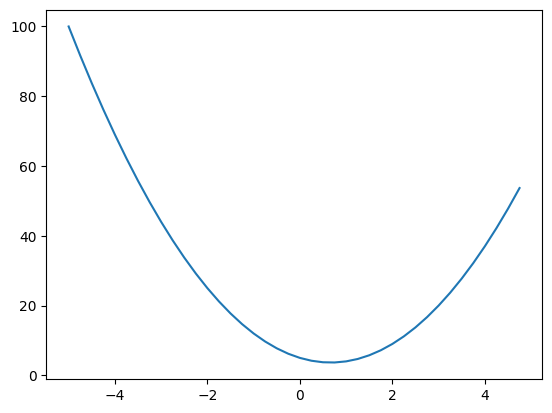

In [4]:
# Understanding the Function with its graph
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

 Understanding Derivatives

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [7]:
# les get lil more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


let's see How the  Slope is actually calculated

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


#### Class Value Function

For this notebook this Will be a very important data type, as most of the stuff in this notebook will be based on it

In [72]:
# Defining The major Value Object
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    # Defining All the attributes for the Value Objects
    self.data = data
    self.prev = set(_children)
    self._op = _op # Stores the Opearand
    self._backward = lambda: None # Backward function initializing with None
    self.label = label
    self.grad = 0.0 # Gradient For the gradient Calcultion (we'll see its use Below)

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    if not isinstance(self, Value):
        self = Value(self)  # Convert self to Value if it's an int/float
    if not isinstance(other, Value):
        other = Value(other)  # Convert other to Value if it's an int/float
    # this will check if the other is a instace of Value, and if not it will wrap the other in Value instance
    out = Value(self.data + other.data, (self, other), '+')
    def _backward(): # this function calculate the gradient of the output wrt to this add operation basically just getting the derivative
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  def __radd__(self, other):  # This is the new method
    return self + other  # Simply call __add__ to reuse the logic

  def __rmul__(self, other): # other * self => this will just swap self with tother
      return self * other


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) # this just converts the other to value object for Multiplication
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out


  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  # Defining Exp Funciton
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.grad * out.data
    out._backward = _backward
    return out

  def __neg__(self): ## Returns the Negation of self
    return self * -1

  def __sub__(self, other): # returns the Subtracttion using the addtion
    return self + (-other)


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def __rtruediv__(self, other): # other / self
        return other * self**-1
  def backward(self):
    ## using Topological Sort
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed (topo):
      node._backward()

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b ; e.label = 'e'
d = e + c ; d.label = 'd'
f = Value(-2.0, label = 'f')
L = f*d ; L.label = 'L'
L
d.prev

{Value(data=-6.0), Value(data=10.0)}

In [73]:
## Now We will be Able to do these
a = Value(2.0)
b = Value(4.0)
a/b
a-b
2+a
2*a
a/2
2/a

Value(data=1.0)

#### Making Function to draw the Graphs for the Opeartions we are going to perform

In [46]:
from graphviz import Digraph


def trace(root):
  ## Building Set of all nodes
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr = {'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{%s | data: %.4f | grad: %.4f }" % (n.label,n.data, n.grad ), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

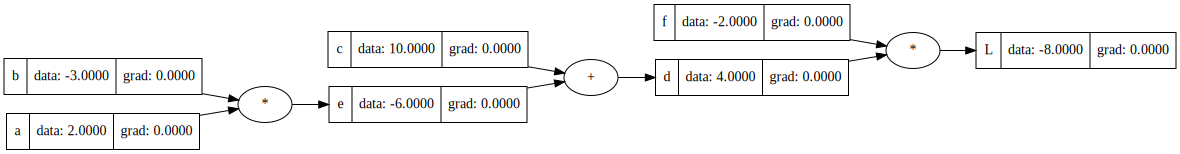

In [47]:
draw_dot(L)

Just a Play Function to See how derivatives Affect

In [48]:
def lol():

  h = 0.0000001


  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b ; e.label = 'e'
  d = e + c ; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = f * d ; L.label = 'L'
  L1 = L.data


  a = Value(2.0+ h, label = 'a')
  b = Value(-3.0 , label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b ; e.label = 'e'
  d = e + c ; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = f * d ; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

lol()

5.999999999062311


#### Calculation of Derivatives and Updating Gradient
- we hahve to find gradient of L wrt to every other variable

i.e.
- dL / dd = f (L = d * f)    || (Derivative of L wrt d)
- dL / df = d (L = d * f)    || (Derivative of L wrt f)
- dd / dc = 1.0 (d = c + e)  || (derivative of d wrt c)
- dL / dc =(dL / dd) * (dd / dc) = f * 1.0 (L = (c + e) * f  ||  d = c + e)
(Applying Chain rule)
=> dL / dc = f * 1.0

Now Similarly, Applying chain rule for e wrt to L
-dd / de = 1.0 (d = c + e) (derivative of d wrt e is 1.0 as c will act as constant)
- dL / de = (dL/dd) * (dd/de) = f * 1.0(L = d * f || d = c + e )
 => dL / de = f * 1.0



In [49]:
L.grad = 1.0 # As derivative to itself will be 1.0
d.grad = f.data # as we saw above
f.grad = d.data
e.grad = f.data * 1.0
c.grad = f.data * 1.0

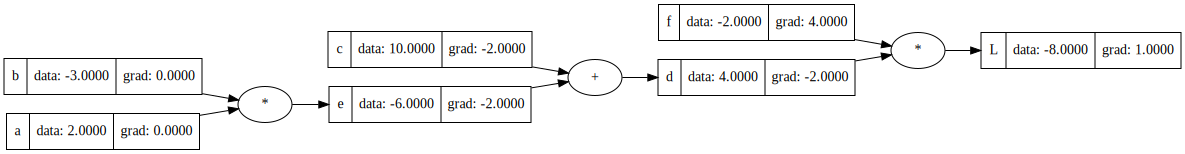

In [50]:
draw_dot(L)

Now Finding :  

e = a * b  
L = d * f => (c + e) * f => (c + (a * b) * f)  

dL / de = f
de / da = b
dL / da  =  (dL / de)  * (de / da)  


=> dL / da = f * b    

Similarly for b,
=>  dL/db = f * a

In [51]:
a.grad = f.data * b.data
b.grad = f.data * a.data

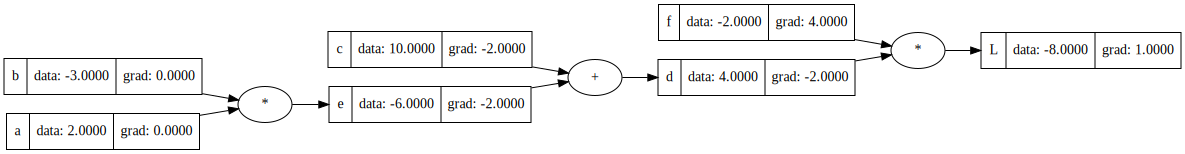

In [52]:
draw_dot(L)

##### Note
Thus Here wee Performed back Propagation simply by Using a simple expression

=> So Basically Back Propagation is nothing but just calculation of gradient of Output wrt to each node

Back propagation is Just recursive application of Chain rule Backwards the Nodes.  
Finding Local derivatives for the Output wrt to each spefic node and finding Gradients(its nothing but just the Derivative of a Output to a spefic node) of those

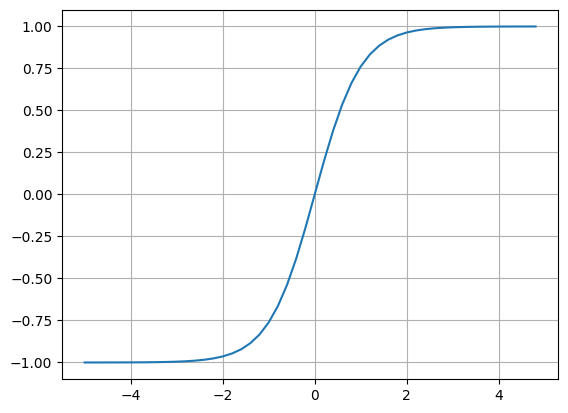

In [53]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

### Manual Back Propagation
intializing two inputs and giving them weights and adding a bias   
then We are finding the value for   
n = x1w1 + x2w2 + b

#### Back Propagation With Neuron(Perceptrons)

#### Structure of Artificial Neuron -

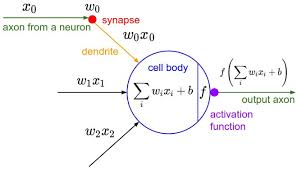  
This is a Mathematical representation of a Perceptron / Neuron



In [54]:
# input x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights of for x1 and x2 , i.e. w1 and w2 respectively
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias for x1 and x2
b = Value(6.8, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2' # weighted sum of the inputs
n = x1w1x2w2 + b; n.label = 'n' # Output  from a Perceptron
o = n.tanh(); o.label = 'o'


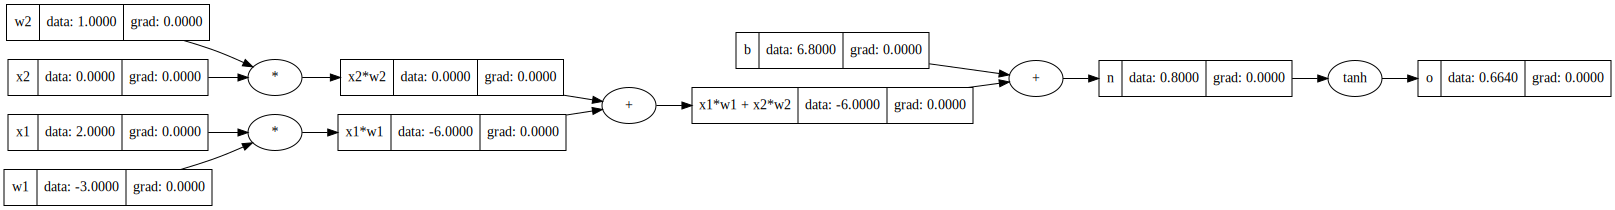

In [55]:
draw_dot(o)

#### Finding derivative now

o wrt to o will be 1

In [56]:
o.grad = 1.0

So basically below we are going to call backward function at each node manually

In [57]:
o._backward()

In [58]:
n._backward()

In [59]:
b._backward()

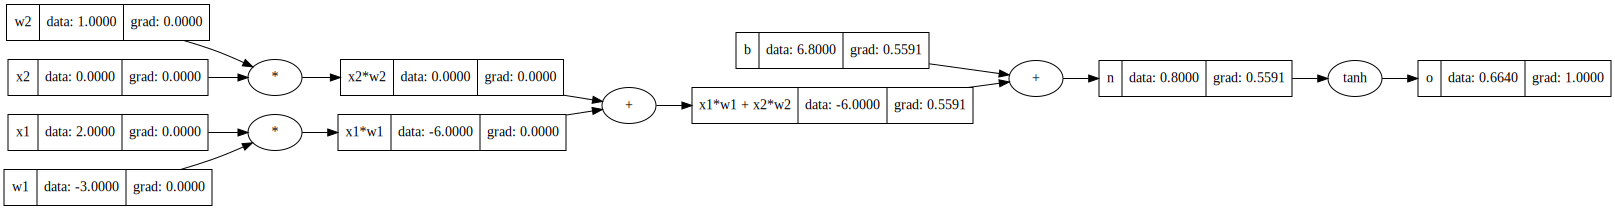

In [60]:
draw_dot(o)

In [61]:
x1w1x2w2._backward()

In [62]:
x1w1._backward()

In [63]:
x2w2._backward()

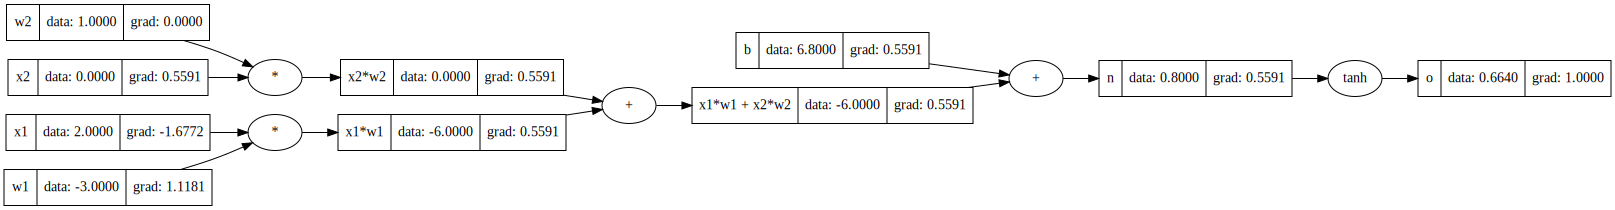

In [64]:
draw_dot(o)

as we know o = tanh(n)  
do / dn = 1 - tanh(n)^2  
therefore do / dn = 1 - o**2  

- Finding do / dx1w1*x2w2  
n = x1w1 + x2w2 + b
dn / dx1w1*x2w2 = 1.0
dn / db = 1.0     
do / dx1w1*x2w2 = (do / dn)  *  (dn / dx1w1*x2w2) => (do / dn )  * 1.0
do / db = (do / dn) * 1.0  
=> Therefore from here we can see that Plus operator just carry through Gradient backwards (if the previous values are jsut weighted sum, that's why the factor it goes backward is 1.0)  [ Will be Useful Below ]


In [65]:
n.grad = 1.0 - o.data**2
x1w1x2w2.grad = n.grad * 1.0
b.grad = n.grad * 1.0
x1w1.grad = n.grad * 1.0
x2w2.grad = n.grad * 1.0
w1.grad = n.grad * x1.data
w2.grad = n.grad * x2.data
x1.grad = n.grad * w1.data
x2.grad = n.grad * w2.data

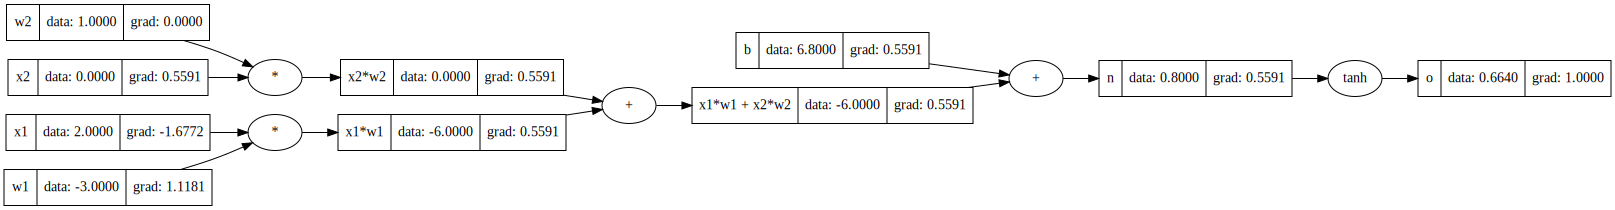

In [66]:
draw_dot(o)

### Automated Back Propagation

In [67]:
o.backward()

#### Bug In Code

Here as we can see both the arrows from a got merged and acting as only one node but we added it twice, and therefore while calculating the gradient it is giving it as wrong !! [ ] NO !!


The bug is When we're trying to acces any nodes more than once or if any node is used more than once.
the Calculation of Grad is giving us wrong as   
"  
self.grad = something  
other.grad = some value  
"  
So basically it jsut re writing the new value on the previou one


==> So instead of just assging the gradients, we should Accumulate the gradients means Which should add the gradients


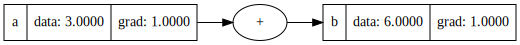

In [70]:
# Exmaple 1 :  Wrong grads
a = Value(3.0, label='a')
b = a+a ; b.label='b'
b.backward()
draw_dot(b)

This Cell was run after we made change and fixed the bug above in the value class   
this shows how the Gadient add up when a specific node is used more than one times and correctly adds up to its gradient instead of rewriting

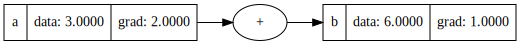

In [74]:
# Exmaple 1 :  After Correcting the bug - grads
a = Value(3.0, label='a')
b = a+a ; b.label='b'
b.backward()
draw_dot(b)

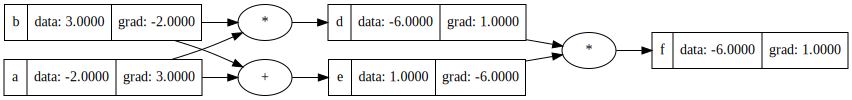

In [71]:
# Exmaple 2 :  Giving wrong gradients
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'
f.backward()
draw_dot(f)

Alright so, This is the Output when the bug is removed, this cell was ran after making the changes in the value class

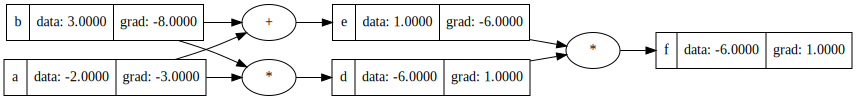

In [75]:
# Exmaple 2 :  After Correcting the Bug - grads
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'
f.backward()
draw_dot(f)

#### Breaking Up a tanh with more operations
Here We are going to Break up the tanh opreation with more fundamental operations for tanh

In [78]:
# input x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights of for x1 and x2 , i.e. w1 and w2 respectively
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias for x1 and x2
b = Value(6.8, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2' # weighted sum of the inputs
n = x1w1x2w2 + b; n.label = 'n' # Output  from a Perceptron
o = n.tanh(); o.label = 'o'
o.backward()

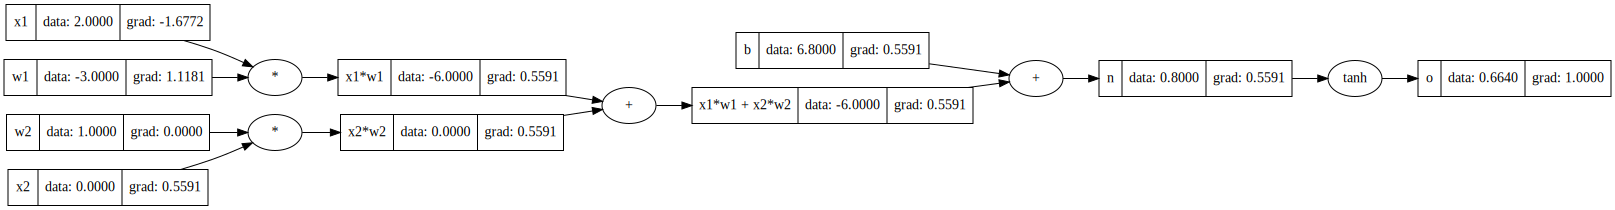

In [79]:
draw_dot(o)

#### Now using the fundamentally the Funtion Tanh instead of using the tanh

In [80]:
# input x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights of for x1 and x2 , i.e. w1 and w2 respectively
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias for x1 and x2
b = Value(6.8, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2' # weighted sum of the inputs
n = x1w1x2w2 + b; n.label = 'n' # Output  from a Perceptron
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
neum = e - 1 ; neum.label = 'neum'
denom = e + 1 ; denom.label = 'denom'
o = neum / denom ; o.label = 'o'
o.backward()

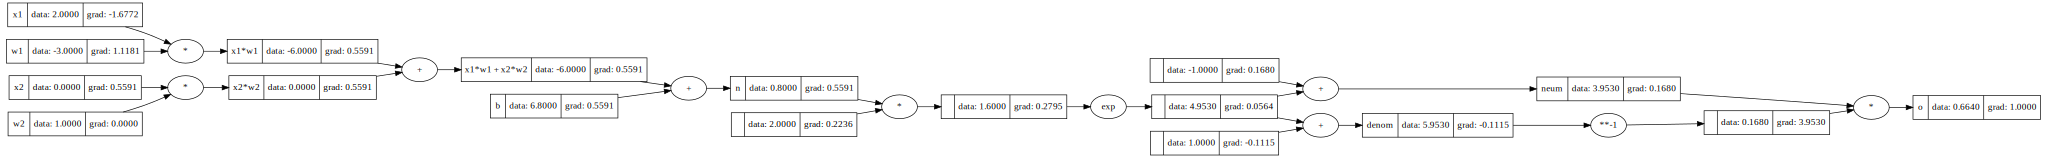

In [81]:
draw_dot(o)

## Using Pytorch

Seeing how can we do all this above in PyTorch

In [82]:
import torch

Using PyTorch

In torch we define tensors,
Tensors are just nothing but various Scalars in many Dimensions, tensors are just scalar units in numerous dimensions

In [83]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [84]:
# Here we make Tensors instead of just scalars
torch.Tensor([2.0]).dtype

torch.float32

In [85]:
# Now typecasting it to double for getting to float64
torch.Tensor([2.0]).double()
# Now we can get Something very Similar to Value(2.0)

tensor([2.], dtype=torch.float64)

In [86]:
x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.8]).double()    ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())# Here similar to our Class Value tensor have .data attribute
# And the .item() just fetches the value and stips off it from the Tensor properties
o.backward()

print('--------')
print('x2:', x2.grad.item())
print('w2:', w2.grad.item())
print('x1:', x1.grad.item())
print('w1:', w1.grad.item())

0.6640368768991465
--------
x2: 0.5590550261180278
w2: 0.0
x1: -1.6771650783540835
w1: 1.1181100522360556


In [87]:
o.item() # Gives the single Number out

0.6640368768991465

In [88]:
x2.grad.item() # grad is

0.5590550261180278

**Conclusion :** *torch can do what we Did with the Class Value, but with the tenosrs this is way more efficiently using tensors. we Can do lots of Operations in parallel with tensors.*




## Building a Neural net Library(Multi-Layer Perceptron) as Micrograd

Defining the Full Nerual network from Scratch

In [89]:
import random

In [93]:
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))


  def __call__(self,x):
    # w = x + b
    act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    ## nin = > Number of inputs to each neuron
    ## nout => Total Number of nuerons in a single layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:
  def __init__(self,nin, nouts):
    # Nouts :  LIst of number of Neuron which we want in All the layers Sequentially
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [94]:
# this Gives a Single layer with 3 neurons where each neuron is able to take 2 inputs
x = [2.0,3.0]
n = Layer(2,4)
n(x)

[Value(data=0.27829612150476096),
 Value(data=-0.8252673064874947),
 Value(data=-0.7519918742427335),
 Value(data=-0.33940730350482157)]

##### Implementing the MLP in this :
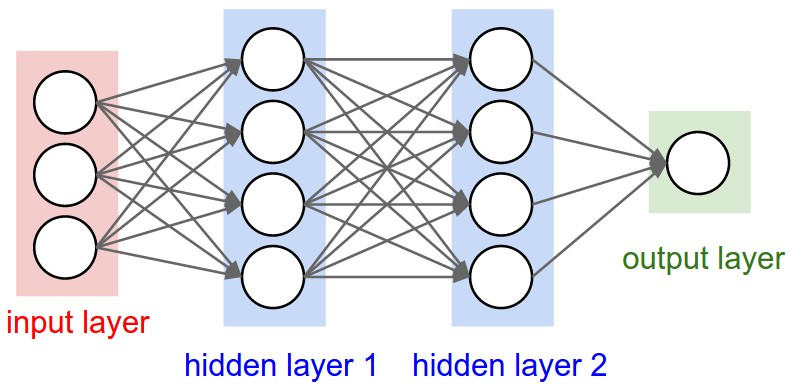

In [96]:
y = [2.0,3.0,4.0] # Number of inputs i.e 3 - dimensional
m = MLP(3,[4,4,1]) # 4 Neuron in two Hidden Layer and the 1 neuron in the Last output Layer
m(y)

Value(data=-0.7863341683870497)

In [97]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] # Desired Targets
ypred = [m(z) for z in xs]
ypred

[Value(data=-0.6068345194694073),
 Value(data=-0.8290461684736552),
 Value(data=-0.5535783541951171),
 Value(data=-0.9598336894510437)]

In [98]:
## Neural net with forwards and Backward pass in a cleaner format

for k in range(50):

  #forward pass
  ypred = [m(z) for z in xs]
  loss = sum((yout - ygt)**2 for ygt , yout in zip(ys, ypred))


  # Backward Pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # Update || Gradient Descent
  for p in m.parameters():
    p.data += -0.05 * p.grad


  print(k , loss.data)


0 6.651382761622449
1 4.9843328361437305
2 1.7682848727357912
3 0.7279017939312746
4 0.006845685830019033
5 0.0009526900073622033
6 0.00046697333801683466
7 0.000648973544395705
8 0.002657658991641138
9 0.0029909071441404467
10 0.003351566646582529
11 0.005462105774766564
12 0.010124681023609422
13 0.01836968891208398
14 0.03069763924168319
15 0.045293916915719955
16 0.0568202822419151
17 0.05957466005968085
18 0.055126229111691294
19 0.04945887604584807
20 0.029077066935996276
21 0.014331160625039755
22 0.007193030712100783
23 0.003550632386671949
24 0.0016958217496256082
25 0.0007881819868427326
26 0.000364039614844587
27 0.0001738862770756183
28 9.078253236584207e-05
29 5.391483419117946e-05
30 3.597947033085956e-05
31 2.56137382035098e-05
32 1.8505407244379203e-05
33 1.317413049459288e-05
34 9.125302733851457e-06
35 6.134511143008165e-06
36 4.033853484997045e-06
37 2.81503446772499e-06
38 7.187168232992745e-06
39 0.0006626058833453166
40 0.07122253929491541
41 2.594079973565634e-07

In [99]:
ypred

[Value(data=1.0),
 Value(data=-0.9999146093687887),
 Value(data=-0.9996454298166793),
 Value(data=1.0)]

Yayyy We Got Almost Perfect Predictions...

So thereforre this is the end this Notebook, It was amazing to Learn nearual nets and Implementation from Scratch From none other than Sir Andrej Kerapathy.